In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pulp

import sys
sys.path.append("../src/data")
import read_instances

## flowshop

defining the problem: a set of jobs must be processed on a series of machines in a specific order. Each job has the same processing sequence across machines.

- given:

    - A set of $n$ jobs: $ J = \{J_1, J_2, \dots, J_n\} $
    - A set of $m$ machines: $ M = \{M_1, M_2, \dots, M_m\} $
    - A processing time $ p_{i,j} $ for each job $ J_i $ on machine $ M_j $.


- decision variables:

    - $C_{i,j}$: completion time of job i on machine j (n_jobs x n_machines)
    - $x_{i,k}$: binary variable indicating whether job i is assigned to position k (n_jobs x n_jobs)
    - M: large constant (used for big-M constraints)

- objective:

    - minimize the makespan $C_{\max}$ (the total completion time of all jobs / the maximum completion time of the last machine) $$ \min C_{\max} $$ where: $$ C_{\max} = \max_{i} C_{i,m} $$

- constraints:

    1. each job is assigned exactly once / each job is scheduled once: $$\sum_{k=1}^{n} x_{i,k} = 1, \quad \forall i \in \{1, \dots, n\}$$

    2. each position is assigned to only one job / each position gets only one job: $$\sum_{i=1}^{n} x_{i,k} = 1, \quad \forall k \in \{1, \dots, n\}$$

    3. first machine processing time constraint: $$C_{i,1} \geq p_{i,1}, \quad \forall i \in \{1, \dots, n\}$$ or $$C_{i,1} \geq \sum_{k=1}^{n} x_{i,k} \cdot p_{i,1}, \quad \forall i \in \{1, \dots, n\}$$

    4. sequential processing on machines: $$C_{i,j} \geq C_{i,j-1} + p_{i,j}, \quad \forall i \in \{1, \dots, n\}, \forall j \in \{2, \dots, m\}$$ or $$C_{i,j} \geq C_{i, j-1} + \sum_{k=1}^{n} x_{i,k} \cdot p_{i,j}, \quad \forall i \in \{1, \dots, n\}, \forall j \in \{2, \dots, m\}$$

    5. job precedence constraint (Big-M formulation) / no job starts before the previous one finishes: $$C_{i,j} \geq C_{i-1,j} + p_{i,j} - M(1 - x_{i,k}), \quad \forall i \in \{2, \dots, n\}, \forall j \in \{1, \dots, m\}, \forall k \in \{1, \dots, n\}$$

    6. makespan constraint: $$C_{\max} \geq C_{i,m}, \quad \forall i \in \{1, \dots, n\}$$


In [2]:
def flowshop_model(num_jobs: int, num_machines: int, processing_times: np.ndarray):

    if processing_times.shape != (num_jobs, num_machines):
        raise ValueError("The dimensions of the processing_times matrix do not match the number of jobs and machines.")

    model = pulp.LpProblem("FlowShop", pulp.LpMinimize)

    # Decision Variables
    C = [[pulp.LpVariable(f"C_{i}_{j}", lowBound=0) for j in range(num_machines)] for i in range(num_jobs)]
    x = [[pulp.LpVariable(f"x_{i}_{k}", cat="Binary") for k in range(num_jobs)] for i in range(num_jobs)]
    C_max = pulp.LpVariable("C_max", lowBound=0)

    # Objective: Minimize makespan
    model += C_max

    # Constraints
    # 1. Each job is assigned exactly once
    for i in range(num_jobs):
        model += pulp.lpSum(x[i][k] for k in range(num_jobs)) == 1

    # 2. Each position gets only one job
    for k in range(num_jobs):
        model += pulp.lpSum(x[i][k] for i in range(num_jobs)) == 1

    # 3. First machine processing constraint
    for i in range(num_jobs):
        # model += C[i][0] >= processing_times[i][0]
        model += C[i][0] >= pulp.lpSum(x[i][k] * processing_times[i][0] for k in range(num_jobs))

    # 4. Sequential job execution on the same machine
    for j in range(1, num_machines):
        for i in range(num_jobs):
            # model += C[i][j] >= C[i][j - 1] + processing_times[i][j]
            model += C[i][j] >= C[i][j - 1] + pulp.lpSum(x[i][k] * processing_times[i][j] for k in range(num_jobs))

    # 5. Job precedence (No overlapping jobs on the same machine)
    M = 1e6  # Large constant for Big-M constraint
    for i in range(1, num_jobs):
        for k in range(num_jobs):
            for j in range(num_machines):
                model += C[i][j] >= C[i-1][j] + processing_times[i][j] - M * (1 - x[i][k])

    # 6. Makespan constraint
    for i in range(num_jobs):
        model += C_max >= C[i][num_machines - 1]

    return model, C, x, C_max

In [3]:
file_path = "../data/flowshop_tai20_5.txt"
flowshop = read_instances.FlowShop(file_path)

flowshop_data = flowshop.data[4]

print(flowshop_data)

num_jobs = flowshop_data["nb_jobs"]
num_machines = flowshop_data["nb_machines"]
processing_times = np.array(flowshop_data["times"]).T
seed = str(flowshop_data["seed"])

print(num_jobs, num_machines, seed)
print(processing_times)

{'nb_jobs': 20, 'nb_machines': 5, 'seed': 495070989, 'upper_bound': 1236, 'lower_bound': 1198, 'times': [[61, 86, 16, 42, 14, 92, 67, 77, 46, 41, 78, 3, 72, 95, 53, 59, 34, 66, 42, 63], [27, 92, 8, 65, 34, 6, 42, 39, 2, 7, 85, 32, 14, 74, 59, 95, 48, 37, 59, 4], [42, 93, 32, 30, 16, 95, 58, 12, 95, 21, 74, 38, 4, 31, 62, 39, 97, 57, 9, 54], [13, 47, 6, 70, 19, 97, 41, 1, 57, 60, 62, 14, 90, 76, 12, 89, 37, 35, 91, 69], [55, 48, 56, 84, 22, 51, 43, 50, 62, 61, 10, 87, 99, 40, 91, 64, 62, 53, 33, 16]]}
20 5 495070989
[[61 27 42 13 55]
 [86 92 93 47 48]
 [16  8 32  6 56]
 [42 65 30 70 84]
 [14 34 16 19 22]
 [92  6 95 97 51]
 [67 42 58 41 43]
 [77 39 12  1 50]
 [46  2 95 57 62]
 [41  7 21 60 61]
 [78 85 74 62 10]
 [ 3 32 38 14 87]
 [72 14  4 90 99]
 [95 74 31 76 40]
 [53 59 62 12 91]
 [59 95 39 89 64]
 [34 48 97 37 62]
 [66 37 57 35 53]
 [42 59  9 91 33]
 [63  4 54 69 16]]


In [4]:
model, C, x, C_max = flowshop_model(num_jobs, num_machines, processing_times)

solver = pulp.PULP_CBC_CMD(msg=False, timeLimit=120, options=[f"randomSeed {seed}"])
print(solver.toDict())

start_time = time.time()

status = model.solve(solver)
objective = pulp.value(model.objective)

runtime = time.time() - start_time

{'solver': 'PULP_CBC_CMD', 'mip': True, 'msg': False, 'keepFiles': False, 'timeLimit': 120, 'options': ['randomSeed 495070989'], 'warmStart': False, 'timeMode': 'elapsed'}


In [5]:
print("Optimal Job Schedule:")
optimal_schedule = [(i, k) for i in range(flowshop_data["nb_jobs"]) for k in range(flowshop_data["nb_jobs"]) if x[i][k].varValue == 1]
for job, position in optimal_schedule:
    print(f"Job {job+1} assigned to position {position}")

Optimal Job Schedule:
Job 1 assigned to position 17
Job 2 assigned to position 13
Job 3 assigned to position 0
Job 4 assigned to position 2
Job 5 assigned to position 10
Job 6 assigned to position 3
Job 7 assigned to position 1
Job 8 assigned to position 12
Job 9 assigned to position 16
Job 10 assigned to position 11
Job 11 assigned to position 4
Job 12 assigned to position 9
Job 13 assigned to position 15
Job 14 assigned to position 7
Job 15 assigned to position 18
Job 16 assigned to position 19
Job 17 assigned to position 5
Job 18 assigned to position 8
Job 19 assigned to position 14
Job 20 assigned to position 6


In [6]:
print(f"Status: {model.status}, Objective: {objective}, Runtime: {runtime:.2f} seconds")
print(f"Optimal Makespan: {pulp.value(C_max)}")

Status: 1, Objective: 1431.0, Runtime: 120.17 seconds
Optimal Makespan: 1431.0


In [7]:
upper_bound = flowshop_data["upper_bound"]
lower_bound = flowshop_data["lower_bound"]
solution_makespan = pulp.value(C_max)

if solution_makespan <= lower_bound:
    print("Optimal solution found!")
elif lower_bound < solution_makespan <= upper_bound:
    print(f"Feasible solution: {solution_makespan}, but may be improved.")
else:
    print(f"Solution {solution_makespan} is above the known upper bound!")

# Compute the performance gap
gap = ((solution_makespan - lower_bound) / (upper_bound - lower_bound)) * 100
print(f"Performance Gap: {gap:.2f}%")

Solution 1431.0 is above the known upper bound!
Performance Gap: 613.16%


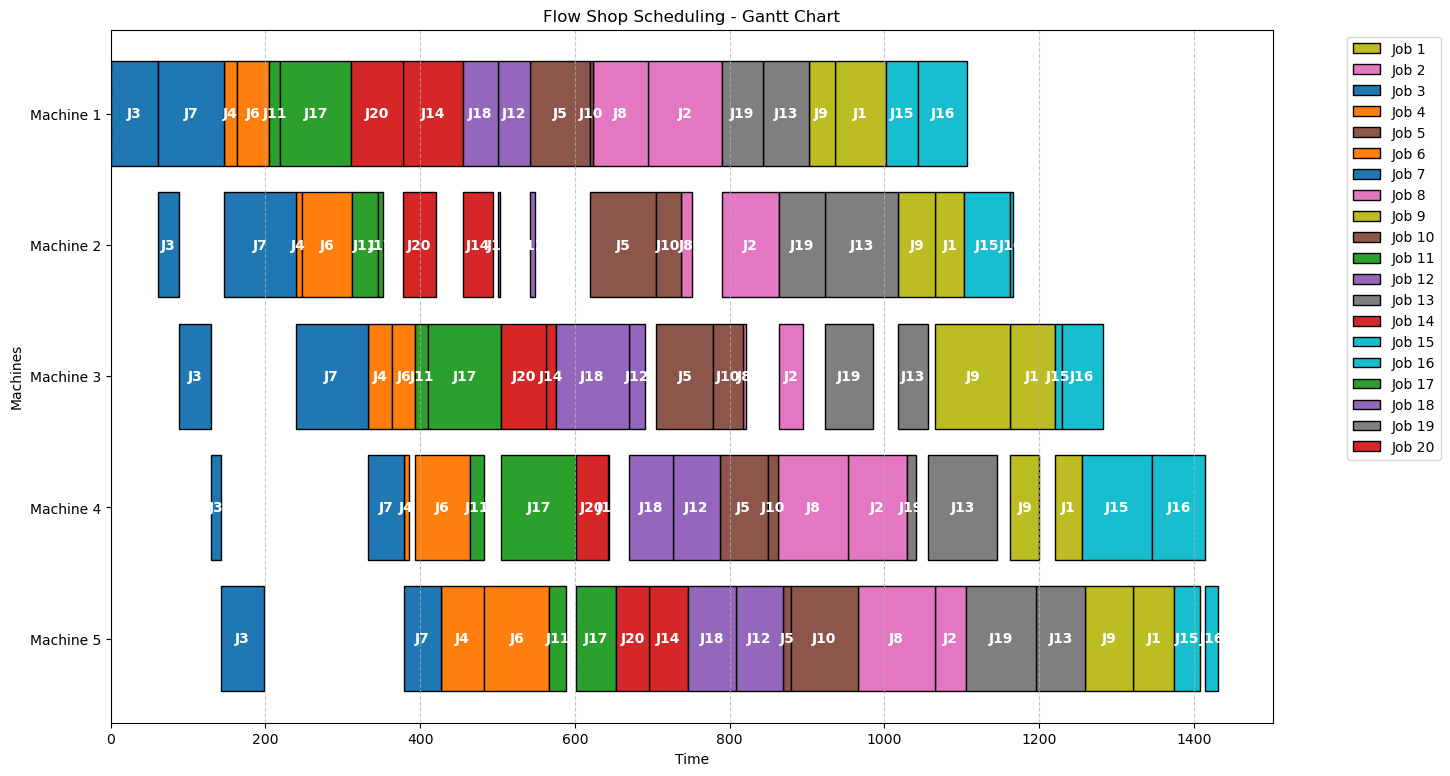

In [8]:
# gantt_chart

fig, ax = plt.subplots(figsize=(15, 9))

colors = plt.get_cmap("tab10", num_jobs)  # colormap for jobs

# get optimal job positions
optimal_schedule = [(i, k) for i in range(num_jobs) for k in range(num_jobs) if x[i][k].varValue == 1]

# plot jobs on each machine
for job, position in optimal_schedule:  
    for j in range(num_machines):
        processing_time = processing_times[position][j]
        start_time = C[position][j].varValue - processing_time
        
        ax.barh(y=j, width=processing_time, left=start_time, 
                color=colors(position % num_jobs), edgecolor="black", label=f"Job {job+1}" if j == 0 else "")

        # text inside bars
        ax.text(start_time + (processing_time / 2), j, f"J{job+1}", 
                ha="center", va="center", color="white", fontsize=10, fontweight="bold")

# labels and title
ax.set_xlabel("Time")
ax.set_ylabel("Machines")
ax.set_title("Flow Shop Scheduling - Gantt Chart")

# configure Y-axis
ax.set_yticks(range(num_machines))
ax.set_yticklabels([f"Machine {j+1}" for j in range(num_machines)])
ax.invert_yaxis() 

ax.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
ax.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()